# Bayesian Regression - Inference Algorithms (Part 2)

This tutorial is based on the official documentation. You can find more details [here](http://pyro.ai/examples/intro_long.html)

In [Part I](bayesian_regression.ipynb), we looked at how to perform inference on a simple Bayesian linear regression model using SVI.  In this tutorial, we'll explore more expressive guides as well as exact inference techniques.  We'll use the same dataset as before.

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
import pyro.optim as optim

pyro.set_rng_seed(1)
# assert pyro.__version__.startswith('0.5.0')

/home/daniel/opt/miniconda3/envs/oed/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

## Bayesian Linear Regression

Our goal is once again to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index, but we will explore more expressive guides.

## Model + Guide

We will write out the model again, similar to that in [Part I](bayesian_regression.ipynb), but explicitly without the use of `nn.Module`.  We will write out each term in the regression, using the same priors. `bA` and `bR` are regression coefficients corresponding to  `is_cont_africa` and `ruggedness`, `a` is the intercept, and `bAR` is the correlating factor between the two features.

Writing down a guide will proceed in close analogy to the construction of our model, with the key difference that the guide parameters need to be trainable. To do this we register the guide parameters in the ParamStore using `pyro.param()`. Note the positive constraints on scale parameters.

In [3]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(8., 1000.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
        
def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [4]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

## SVI

As before, we will use SVI to perform inference.

In [5]:
svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
num_iters = 10000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

/home/daniel/opt/miniconda3/envs/oed/lib/python3.11/site-packages/pyro/infer/svi.py:57: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  warnings.warn(
Elbo loss: 5800.071345984936
Elbo loss: 628.4036766886711
Elbo loss: 580.5144794285297
Elbo loss: 559.3134279251099
Elbo loss: 475.7638465464115
Elbo loss: 483.09788036346436
Elbo loss: 463.26280480623245
Elbo loss: 431.5989167690277
Elbo loss: 404.81118500232697
Elbo loss: 371.74018293619156
Elbo loss: 306.60166281461716
Elbo loss: 286.20125436782837
Elbo loss: 259.7068447470665
Elbo loss: 250.598781645298
Elbo loss: 254.11627036333084
Elbo loss: 252.16992914676666
Elbo loss: 267.0337401628494
Elbo loss: 252.09635835886002
Elbo loss: 253.12625759840012
Elbo loss: 252.6920239329338


In [6]:
svi_diagnorm_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)

/home/daniel/opt/miniconda3/envs/oed/lib/python3.11/site-packages/pyro/infer/svi.py:99: FutureWarning: The `SVI.run` method is deprecated and will be removed in a future release. For inference, use `SVI.step` directly, and for predictions, use the `pyro.infer.Predictive` class.
  warnings.warn(


Let us observe the posterior distribution over the different latent variables in the model.

In [7]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

svi_samples = {site: EmpiricalMarginal(svi_diagnorm_posterior, sites=site)
                     .enumerate_support().detach().cpu().numpy()
               for site in sites}

for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%       95%
0  9.192743  0.073744  9.074027  9.140702  9.197718  9.243423  9.303659 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0 -1.853577  0.134715 -2.073369 -1.940101 -1.849553 -1.762716 -1.641578 

Site: bR
       mean      std        5%      25%       50%       75%       95%
0 -0.172035  0.04103 -0.239187 -0.20123 -0.169727 -0.143967 -0.103523 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.333441  0.083769  0.190482  0.277777  0.334467  0.393399  0.474023 

Site: sigma
       mean      std        5%       25%       50%       75%       95%
0  0.956975  0.05094  0.872172  0.925918  0.956211  0.991062  1.037548 



## HMC

In contrast to using variational inference which gives us an approximate posterior over our latent variables, we can also do exact inference using [Markov Chain Monte Carlo](http://docs.pyro.ai/en/dev/mcmc.html) (MCMC), a class of algorithms that in the limit, allow us to draw unbiased samples from the true posterior. The algorithm that we will be using is called the No-U Turn Sampler (NUTS) \[1\], which provides an efficient and automated way of running Hamiltonian Monte Carlo.  It is slightly slower than variational inference, but provides an exact estimate.

In [8]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [00:15, 78.99it/s, step size=4.44e-01, acc. prob=0.914]


In [9]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%       95%
0  9.173275  0.135609  8.960023  9.078658  9.168869  9.268813  9.392868 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0 -1.823963  0.217948 -2.189092 -1.970843 -1.828697 -1.674153 -1.481475 

Site: bAR
       mean       std        5%       25%      50%      75%       95%
0  0.341256  0.128783  0.138157  0.248471  0.34062  0.43139  0.555454 

Site: bR
       mean       std        5%       25%       50%       75%       95%
0 -0.179394  0.073648 -0.302677 -0.228687 -0.177532 -0.127046 -0.062822 

Site: sigma
      mean       std        5%       25%       50%       75%       95%
0  0.94853  0.051598  0.869521  0.912697  0.945438  0.982512  1.037401 



## Comparing Posterior Distributions

Let us compare the posterior distribution of the latent variables that we obtained from variational inference with those from Hamiltonian Monte Carlo. As can be seen below, for Variational Inference, the marginal distribution of the different regression coefficients is under-dispersed w.r.t. the true posterior (from HMC). This is an artifact of the *KL(q||p)* loss (the KL divergence of the true posterior from the approximate posterior) that is minimized by Variational Inference.

This can be better seen when we plot different cross sections from the joint posterior distribution overlaid with the approximate posterior from variational inference. Note that since our variational family has diagonal covariance, we cannot model any correlation between the latents and the resulting approximation is overconfident (under-dispersed)

/tmp/ipykernel_48195/1188723142.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
/tmp/ipykernel_48195/1188723142.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_samples[site], ax=ax, label="HMC")
/tmp/ipykernel_48195/1188723142.py:5:

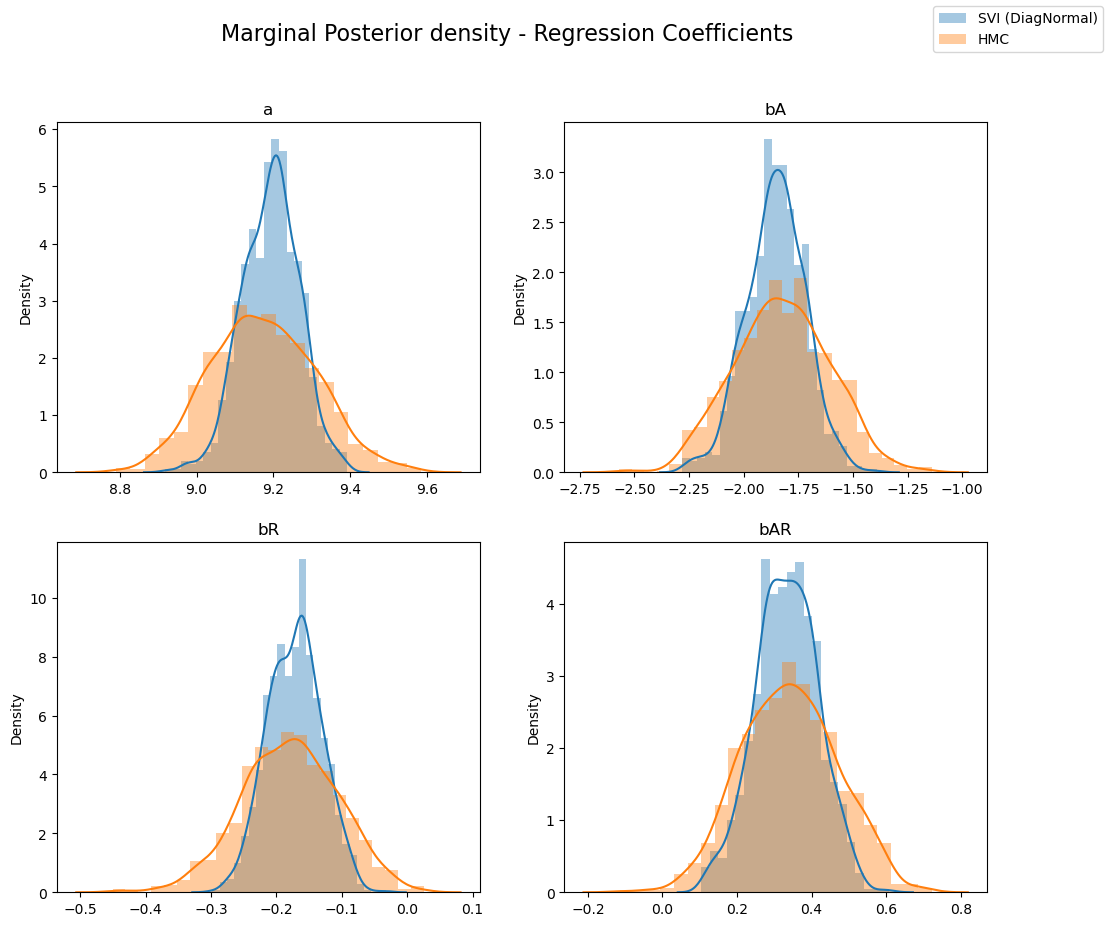

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

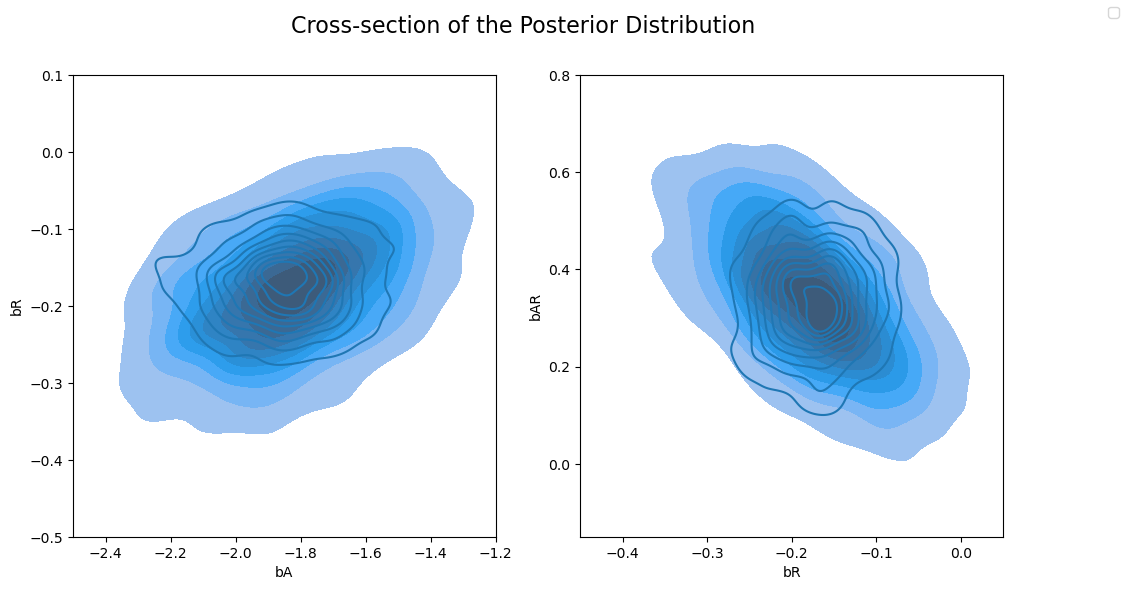

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], fill=True, label="HMC")
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], fill=True, label="HMC")
sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## MultivariateNormal Guide

As comparison to the previously obtained results from Diagonal Normal guide, we will now use a guide that generates samples from a Cholesky factorization of a multivariate normal distribution.  This allows us to capture the correlations between the latent variables via a covariance matrix.  If we wrote this manually, we would need to combine all the latent variables so we could sample a Multivarite Normal jointly.

In [12]:
from pyro.infer.autoguide import init_to_mean

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

/home/daniel/opt/miniconda3/envs/oed/lib/python3.11/site-packages/pyro/infer/svi.py:57: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  warnings.warn(
Elbo loss: 448.4429086446762
Elbo loss: 249.89061623811722
Elbo loss: 253.62693458795547
Elbo loss: 252.43248850107193
Elbo loss: 251.79915416240692
Elbo loss: 252.10362207889557
Elbo loss: 252.0010456442833
Elbo loss: 252.2050803899765
Elbo loss: 251.52222204208374
Elbo loss: 252.61213892698288
Elbo loss: 252.2844496369362
Elbo loss: 251.55906397104263
Elbo loss: 251.8655264377594
Elbo loss: 251.8110550045967
Elbo loss: 251.51178205013275
Elbo loss: 251.50510227680206
Elbo loss: 252.11643999814987
Elbo loss: 252.36459875106812
Elbo loss: 252.3051722049713
Elbo loss: 252.43775409460068


Let's look at the shape of the posteriors again.  You can see the multivariate guide is able to capture more of the true posterior.

/home/daniel/opt/miniconda3/envs/oed/lib/python3.11/site-packages/pyro/infer/svi.py:99: FutureWarning: The `SVI.run` method is deprecated and will be removed in a future release. For inference, use `SVI.step` directly, and for predictions, use the `pyro.infer.Predictive` class.
  warnings.warn(
/tmp/ipykernel_48195/1683975307.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(svi_mvn_samples[site], ax=ax, label="SVI (Multivariate Normal)")
/tmp/ipykernel_48195/1683975307.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function 

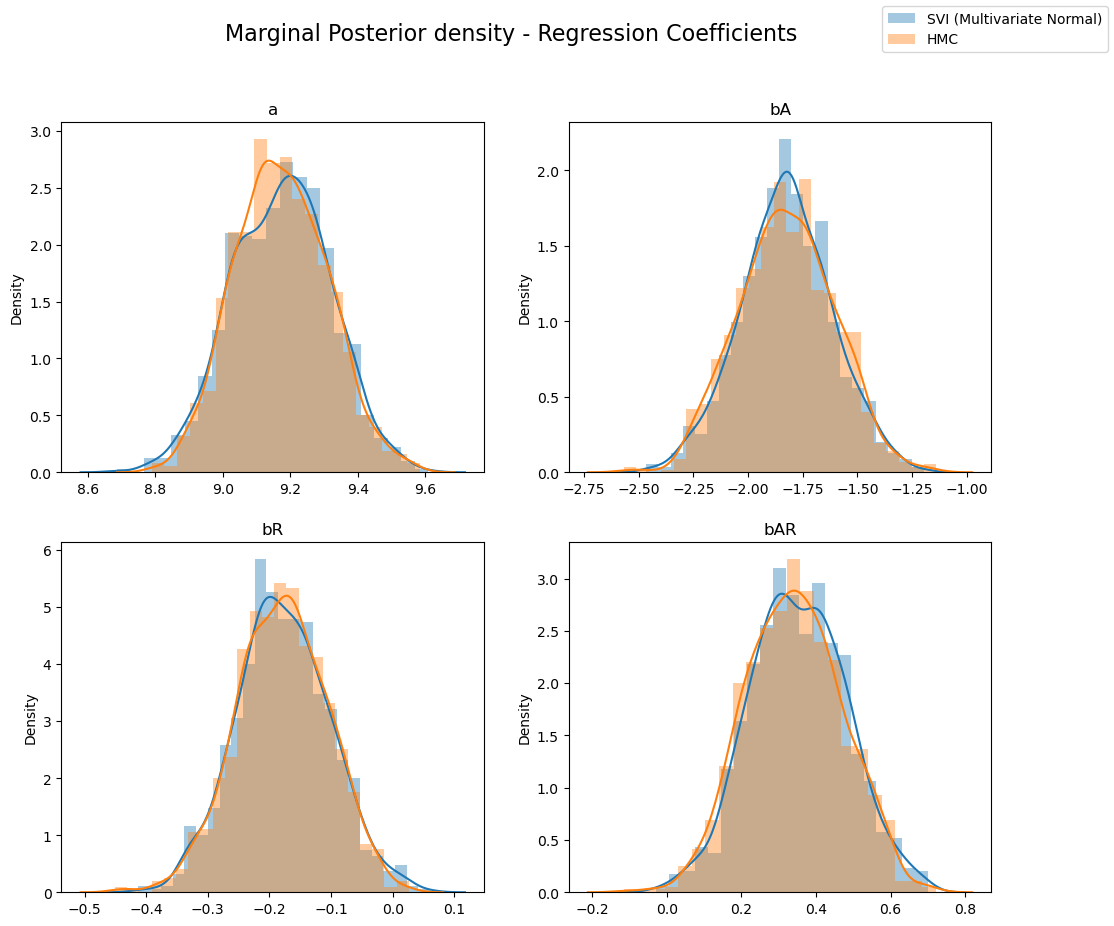

In [13]:
svi_mvn_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)
svi_mvn_samples = {site: EmpiricalMarginal(svi_mvn_posterior, sites=site).enumerate_support()
                         .detach().cpu().numpy()
                   for site in sites}
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_mvn_samples[site], ax=ax, label="SVI (Multivariate Normal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

Now let's compare the posterior computed by the Diagonal Normal guide vs the Multivariate Normal guide.  Note that the multivariate distribution is more dispresed than the Diagonal Normal.

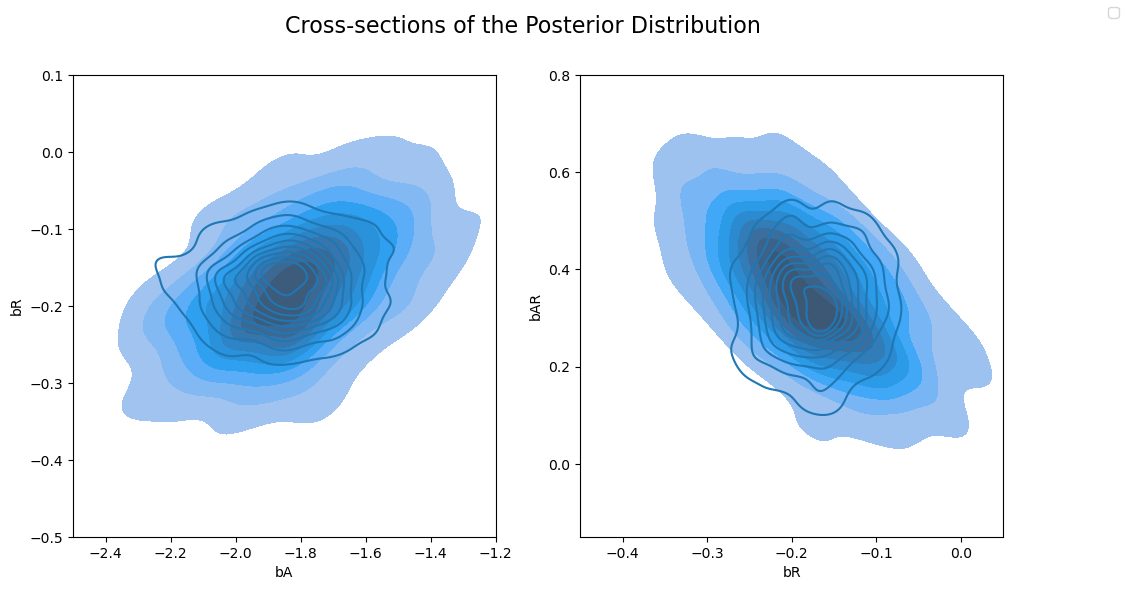

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], label="HMC")
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], fill=True, label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1], label="SVI (Diagonal Normal)")
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], fill=True, label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

and the Multivariate guide with the posterior computed by HMC.  Note that the Multivariate guide better captures the true posterior.

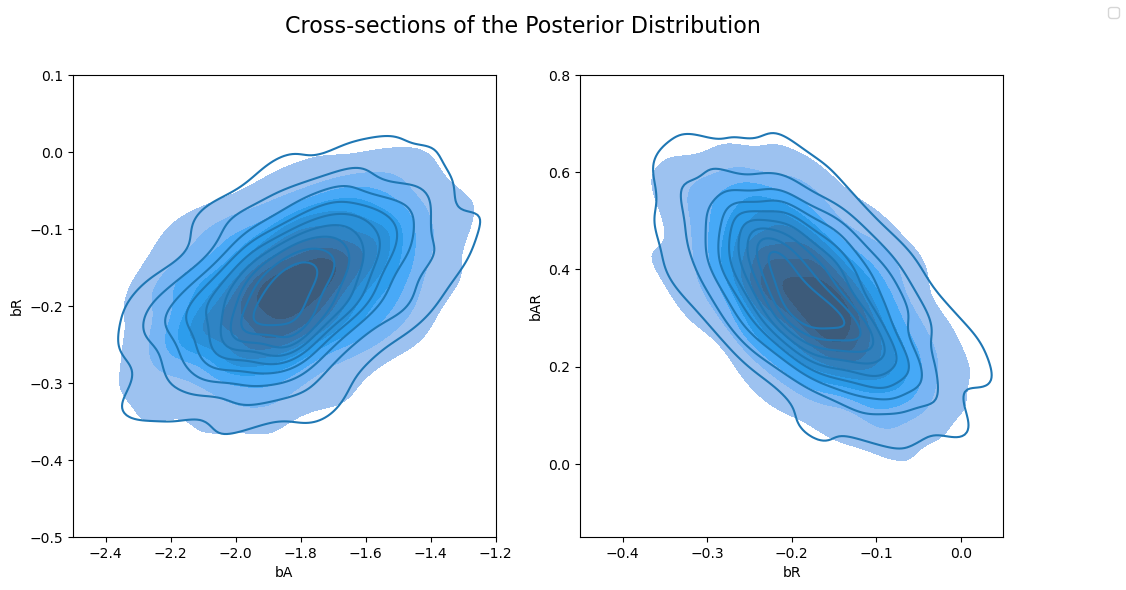

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], fill=True, label="HMC")
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], fill=True, label="HMC")
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## References
[1] Hoffman, Matthew D., and Andrew Gelman. "The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo." Journal of Machine Learning Research 15.1 (2014): 1593-1623.  https://arxiv.org/abs/1111.4246.